<a href="https://colab.research.google.com/github/sc-AhmedAttia/SuperResolution/blob/main/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir output

In [30]:
!mkdir output/visualizations/

In [2]:
!mkdir tools

In [3]:
!pip install tensorflow pillow imutils

In [4]:
!wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz

--2022-01-05 08:35:17--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1, 2620:12a:8000::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2022-01-05 08:35:18--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2022-01-05 08:35:18--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

In [5]:
!tar xvf BSR_bsds500.tgz

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
BSR/bench/source/Matrix.hh
BSR/bench/source/csa.hh
BSR/bench/source/String.hh
BSR/bench/bench_bsds500.m
BSR/bench/data/
BSR/bench/data/groundTruth/
BSR/bench/data/groundTruth/6046.mat
BSR/bench/data/groundTruth/2018.mat
BSR/bench/data/groundTruth/8068.mat
BSR/bench/

In [6]:
%%writefile tools/__init__.py
# init

Writing tools/__init__.py


In [7]:
%%writefile tools/config.py
# import the necessary packages
import os

# specify root path to the BSDS500 dataset
ROOT_PATH = os.path.join("BSR", "BSDS500", "data", "images")

# specify paths to the different splits of the dataset
TRAIN_SET = os.path.join(ROOT_PATH, "train")
VAL_SET = os.path.join(ROOT_PATH, "val")
TEST_SET = os.path.join(ROOT_PATH, "test")

# specify the initial size of the images and downsampling factor
ORIG_SIZE = (300, 300)
DOWN_FACTOR = 3

# specify number of RDB blocks, batch size, number of epochs, and
# initial learning rate to train our model
RDB_LAYERS = 3
BATCH_SIZE = 8
EPOCHS = 100
LR = 1e-3

#define paths to serialize trained model, training history plot, and
# path to our inference visualizations
SUPER_RES_MODEL = os.path.join("output", "super_res_model")
TRAINING_PLOT = os.path.join("output", "training.png")
VISUALIZATION_PATH = os.path.join("output", "visualizations")

Writing tools/config.py


In [8]:
%%writefile tools/data_utils.py
# import the necessary packages
from . import config
import tensorflow as tf

def process_input(imagePath, downFactor=config.DOWN_FACTOR):
	# determine size of the downsampled images
	resizeShape = config.ORIG_SIZE[0] // downFactor

	# load the original image from disk, decode it as a JPEG image,
	# scale its pixel values to [0, 1] range, and resize the image
	origImage = tf.io.read_file(imagePath)
	origImage = tf.image.decode_jpeg(origImage, 3)
	origImage = tf.image.convert_image_dtype(origImage, tf.float32)
	origImage = tf.image.resize(origImage, config.ORIG_SIZE,
		method="area") 
 
  # convert the color space from RGB to YUV and only keep the Y
	# channel (which is our target variable)
	origImageYUV = tf.image.rgb_to_yuv(origImage)
	(target, _, _) = tf.split(origImageYUV, 3, axis=-1)

	# resize the target to a lower resolution
	downImage = tf.image.resize(target, [resizeShape, resizeShape],
		method="area")

	# clip the values of the input and target to [0, 1] range
	target = tf.clip_by_value(target, 0.0, 1.0)
	downImage = tf.clip_by_value(downImage, 0.0, 1.0)

	# return a tuple of the downsampled image and original image
	return (downImage, target)

Writing tools/data_utils.py


In [9]:
%%writefile tools/subpixel_net.py
# import the necessary packages
from . import config
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf

def rdb_block(inputs, numLayers):
	# determine the number of channels present in the current input
	# and initialize a list with the current inputs for concatenation
	channels = inputs.get_shape()[-1]
	storedOutputs = [inputs]

  # iterate through the number of residual dense layers
	for _ in range(numLayers):
		# concatenate the previous outputs and pass it through a
		# CONV layer, and append the output to the ongoing concatenation
		localConcat = tf.concat(storedOutputs, axis=-1)
		out = Conv2D(filters=channels, kernel_size=3, padding="same",
			activation="relu",
			kernel_initializer="Orthogonal")(localConcat)
		storedOutputs.append(out)
  
  # concatenate all the outputs, pass it through a pointwise
	# convolutional layer, and add the outputs to initial inputs
	finalConcat = tf.concat(storedOutputs, axis=-1)
	finalOut = Conv2D(filters=channels, kernel_size=1,
		padding="same", activation="relu",
		kernel_initializer="Orthogonal")(finalConcat)
	finalOut = Add()([finalOut, inputs])

	# return the final output
	return finalOut

def get_subpixel_net(downsampleFactor=config.DOWN_FACTOR, channels=1,
	rdbLayers=config.RDB_LAYERS):
	# initialize an input layer
	inputs = Input((None, None, 1))

	# pass the inputs through a CONV => CONV block
	x = Conv2D(64, 5, padding="same", activation="relu",
		kernel_initializer="Orthogonal")(inputs)
	x = Conv2D(64, 3, padding="same", activation="relu",
		kernel_initializer="Orthogonal")(x)

	# pass the outputs through an RDB => CONV => RDB block
	x = rdb_block(x, numLayers=rdbLayers)
	x = Conv2D(32, 3, padding="same", activation="relu",
		kernel_initializer="Orthogonal")(x)
	x = rdb_block(x, numLayers=rdbLayers)
 
  # pass the inputs through a final CONV layer such that the
	# channels of the outputs can be spatially organized into
	# the output resolution
	x = Conv2D(channels * (downsampleFactor ** 2), 3, padding="same",
		activation="relu", kernel_initializer="Orthogonal")(x)
	outputs = tf.nn.depth_to_space(x, downsampleFactor)

	# construct the final model and return it
	model = Model(inputs, outputs)
	return model

Writing tools/subpixel_net.py


In [28]:
# import the necessary packages
from tools.data_utils import process_input
from tools import config
from tools import subpixel_net

import os
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

In [10]:
def psnr(orig, pred):
	# cast the target images to integer
	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)

	# cast the predicted images to integer
	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)

	# return the psnr
	return tf.image.psnr(orig, pred, max_val=255)

In [11]:
# define autotune flag for performance optimization
AUTO = tf.data.AUTOTUNE

# load the image paths from disk and initialize TensorFlow Dataset
# objects
print("[INFO] loading images from disk...")
trainPaths = list(paths.list_images(config.TRAIN_SET))
valPaths = list(paths.list_images(config.VAL_SET))
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
valDS = tf.data.Dataset.from_tensor_slices(valPaths)

[INFO] loading images from disk...


In [12]:
# prepare data loaders
print("[INFO] preparing data loaders...")
trainDS = trainDS.map(process_input,
					  num_parallel_calls=AUTO).batch(
	config.BATCH_SIZE).prefetch(AUTO)
valDS = valDS.map (process_input,
				  num_parallel_calls=AUTO).batch(
	config.BATCH_SIZE).prefetch(AUTO)

# initialize, compile, and train the model
print("[INFO] initializing and training model...")
model = subpixel_net.get_subpixel_net()
model.compile(optimizer="adam", loss="mse", metrics=psnr)
H = model.fit(trainDS, validation_data=valDS, epochs=config.EPOCHS)

[INFO] preparing data loaders...
[INFO] initializing and training model...
Epoch 1/100
25/25 [==============================] - 22s 304ms/step - loss: 0.0477 - psnr: 15.1416 - val_loss: 0.0086 - val_psnr: 19.8240
Epoch 2/100
25/25 [==============================] - 6s 248ms/step - loss: 0.0065 - psnr: 21.2661 - val_loss: 0.0053 - val_psnr: 21.0199
Epoch 3/100
25/25 [==============================] - 6s 246ms/step - loss: 0.0043 - psnr: 23.1262 - val_loss: 0.0037 - val_psnr: 23.4051
Epoch 4/100
25/25 [==============================] - 6s 247ms/step - loss: 0.0033 - psnr: 24.2680 - val_loss: 0.0033 - val_psnr: 22.5899
Epoch 5/100
25/25 [==============================] - 6s 246ms/step - loss: 0.0029 - psnr: 24.5693 - val_loss: 0.0029 - val_psnr: 24.8890
Epoch 6/100
25/25 [==============================] - 6s 247ms/step - loss: 0.0029 - psnr: 24.4501 - val_loss: 0.0027 - val_psnr: 24.7461
Epoch 7/100
25/25 [==============================] - 6s 248ms/step - loss: 0.0026 - psnr: 25.1933 - va

[INFO] serializing model...
INFO:tensorflow:Assets written to: output/super_res_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


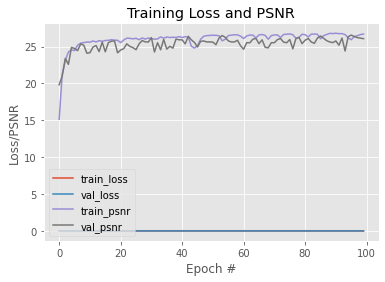

In [13]:
# prepare training plot of the model and serialize it
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["psnr"], label="train_psnr")
plt.plot(H.history["val_psnr"], label="val_psnr")
plt.title("Training Loss and PSNR")
plt.xlabel("Epoch #")
plt.ylabel("Loss/PSNR")
plt.legend(loc="lower left")
plt.savefig(config.TRAINING_PLOT)
# serialize the trained model
print("[INFO] serializing model...")
model.save(config.SUPER_RES_MODEL)

In [14]:
def load_image(imagePath):
	# load image from disk and downsample it using the bicubic method
	orig = load_img(imagePath)
	downsampled = orig.resize((orig.size[0] // config.DOWN_FACTOR,
		orig.size[1] // config.DOWN_FACTOR), Image.BICUBIC)
	# return a tuple of the original and downsampled image
	return (orig, downsampled)

In [15]:
def get_y_channel(image):
	# convert the image to YCbCr colorspace and then split it to get the
	# individual channels
	ycbcr = image.convert("YCbCr")
	(y, cb, cr) = ycbcr.split()
	# convert the y-channel to a numpy array, cast it to float, and
	# scale its pixel range to [0, 1]
	y = np.array(y)
	y = y.astype("float32") / 255.0
	# return a tuple of the individual channels
	return (y, cb, cr)

In [16]:
def clip_numpy(image):
	# cast image to integer, clip its pixel range to [0, 255]
	image = tf.cast(image * 255.0, tf.uint8)
	image = tf.clip_by_value(image, 0, 255).numpy()
	# return the image
	return image

In [17]:
def postprocess_image(y, cb, cr):
	# do a bit of initial preprocessing, reshape it to match original
	# size, and then convert it to a PIL Image
	y = clip_numpy(y).squeeze()
	y = y.reshape(y.shape[0], y.shape[1])
	y = Image.fromarray(y, mode="L")
	# resize the other channels of the image to match the original
	# dimension
	outputCB= cb.resize(y.size, Image.BICUBIC)
	outputCR= cr.resize(y.size, Image.BICUBIC)
	# merge the resized channels altogether and return it as a numpy
	# array
	final = Image.merge("YCbCr", (y, outputCB, outputCR)).convert("RGB")
	return np.array(final)

In [22]:
# load the test image paths from disk and select ten paths randomly
print("[INFO] loading test images...")
testPaths = list(paths.list_images(config.TEST_SET))
currentTestPaths = np.random.choice(testPaths, 10)
# load our super-resolution model from disk
print("[INFO] loading model...")
superResModel = load_model(config.SUPER_RES_MODEL,
	custom_objects={"psnr" : psnr})

[INFO] loading test images...
[INFO] loading model...


[INFO] performing predictions...


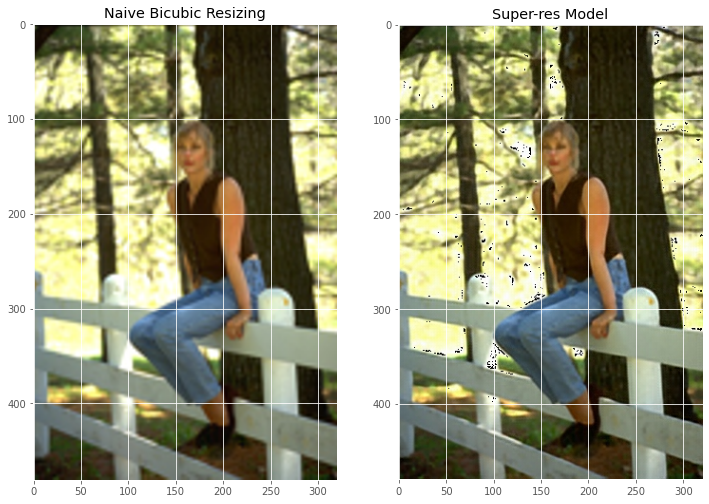

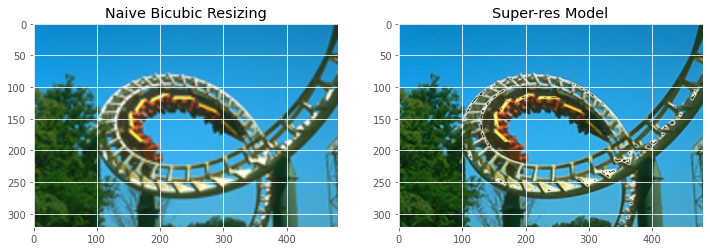

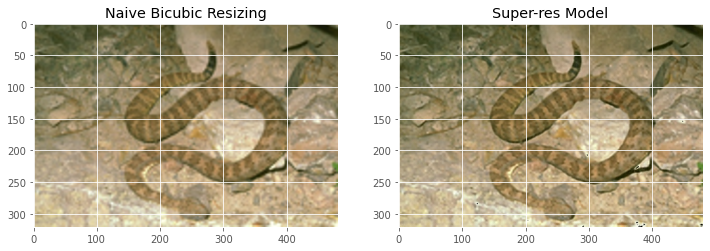

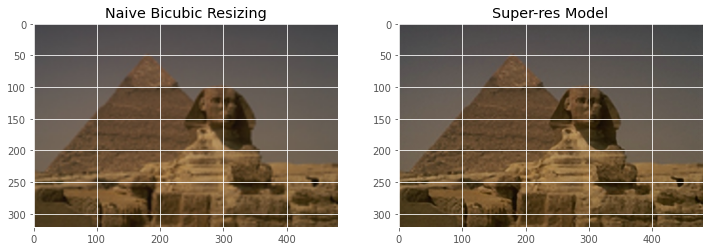

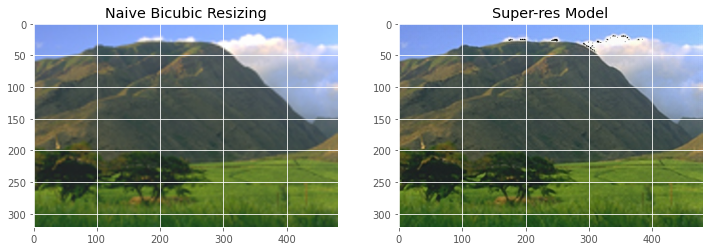

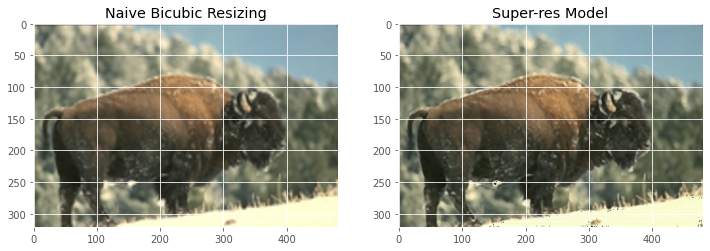

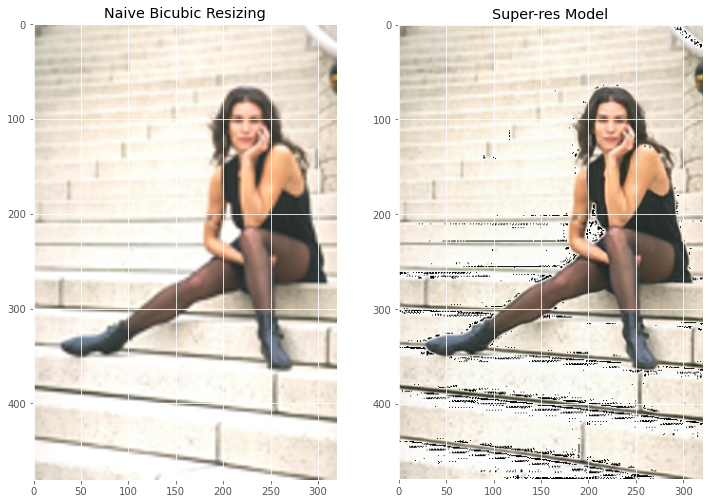

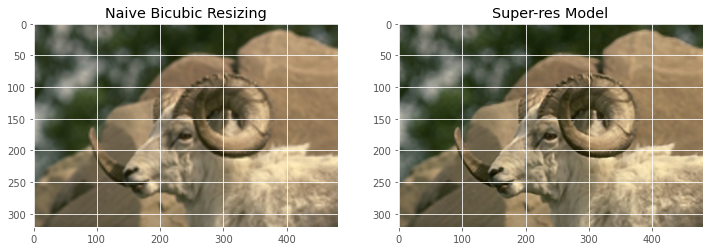

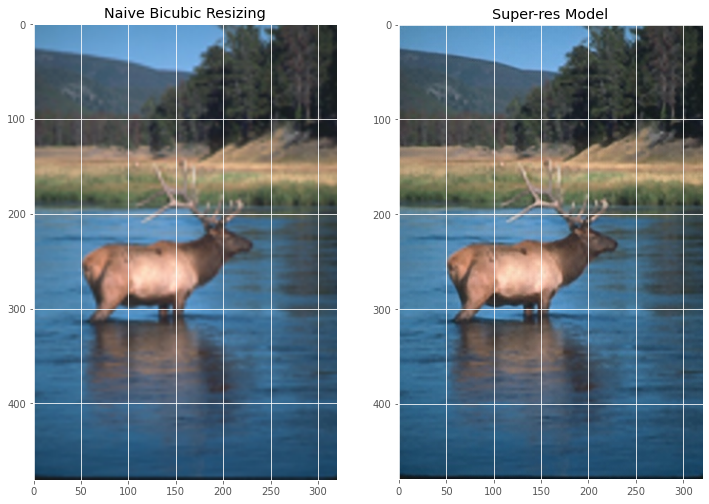

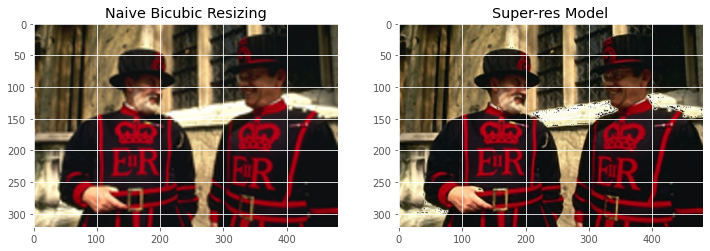

In [31]:
# iterate through our test image paths
print("[INFO] performing predictions...")
for (i, path) in enumerate(currentTestPaths):
	# grab the original and the downsampled images from the
	# current path
	(orig, downsampled) = load_image(path)
	# retrieve the individual channels of the current image and perform
	# inference
	(y, cb, cr) = get_y_channel(downsampled)
	upscaledY = superResModel.predict(y[None, ...])[0]
	# postprocess the output and apply the naive bicubic resizing to
	# the downsampled image for comparison
	finalOutput = postprocess_image(upscaledY, cb, cr)
	naiveResizing = downsampled.resize(orig.size, Image.BICUBIC)
	# visualize the results and save them to disk
	path = os.path.join(config.VISUALIZATION_PATH, f"{i}_viz.png")
	(fig, (ax1, ax2)) = plt.subplots(ncols=2, figsize=(12, 12))
	ax1.imshow(naiveResizing)
	ax2.imshow(finalOutput.astype("int"))
	ax1.set_title("Naive Bicubic Resizing")
	ax2.set_title("Super-res Model")
	fig.savefig(path, dpi=300, bbox_inches="tight")

In [48]:
!sudo add-apt-repository -y ppa:git-core/ppa
!sudo apt update
!sudo apt install git -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Get:15 http://se

In [71]:
!rm -r .git/

In [81]:
!ls -a .

.   BSR		     .config  .gitignore  README.md    tools
..  BSR_bsds500.tgz  .git     output	  sample_data


In [76]:
!git config --global user.email "my_email"
!git config --global user.name "my_user"

In [77]:
!git init -b main

Initialized empty Git repository in /content/.git/


In [78]:
!git remote add origin https://<USERNAME>:<Token>@github.com/<USERNAME>/reponame.git

In [ ]:
!git remote -v

In [80]:
!git pull origin main

remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 1.57 KiB | 1.57 MiB/s, done.
From https://github.com/sc-AhmedAttia/SuperResolution
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [82]:
!git add output/ tools/

In [83]:
!git commit -m "Implementation"

[main fcc59c1] Implementation
 19 files changed, 161 insertions(+)
 create mode 100644 output/super_res_model/keras_metadata.pb
 create mode 100644 output/super_res_model/saved_model.pb
 create mode 100644 output/super_res_model/variables/variables.data-00000-of-00001
 create mode 100644 output/super_res_model/variables/variables.index
 create mode 100644 output/training.png
 create mode 100644 output/visualizations/0_viz.png
 create mode 100644 output/visualizations/1_viz.png
 create mode 100644 output/visualizations/2_viz.png
 create mode 100644 output/visualizations/3_viz.png
 create mode 100644 output/visualizations/4_viz.png
 create mode 100644 output/visualizations/5_viz.png
 create mode 100644 output/visualizations/6_viz.png
 create mode 100644 output/visualizations/7_viz.png
 create mode 100644 output/visualizations/8_viz.png
 create mode 100644 output/visualizations/9_viz.png
 create mode 100644 tools/__init__.py
 create mode 100644 tools/config.py
 create mode 100644 tools/da

In [84]:
!git push origin main

Enumerating objects: 27, done.
Counting objects: 100% (27/27), done.
Delta compression using up to 2 threads
Compressing objects: 100% (25/25), done.
Writing objects: 100% (26/26), 17.68 MiB | 13.31 MiB/s, done.
Total 26 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/sc-AhmedAttia/SuperResolution.git
   b3d76db..fcc59c1  main -> main
